<a href="https://colab.research.google.com/github/Alexnder77/DeepLearning--methods-and-applications/blob/main/Lab1_Convolutional_Neural_Networks_on_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5TF078 Deep Learning Course
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST

Code from Tomas Nordström, Umeå University





# First we initilize our Python environment

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist 
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt


TensorFlow version: 2.8.0
Keras version: 2.8.0


In [ ]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-6526a14c-f0f5-2c18-f260-6d3bed67dfdf)


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tensorflow.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

In [ ]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) : 
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) : 
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) : 
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `tensorflow.keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes! 

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [ ]:
# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: Pullover


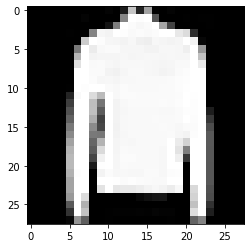

Label: Shirt


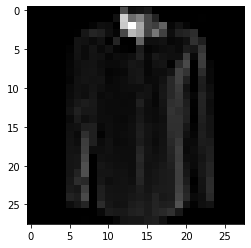

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(np.squeeze(train_images[index], axis=-1))
  plt.gray()
  plt.grid(False)
  plt.show(block=False)

# Define a convolutional network model

## Define the model using Keras

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=64, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,606,666
Trainable params: 1,606,666
Non-trainable params: 0
_________________________________________________________________


# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

# Run the training

In [ ]:
epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3248 - categorical_accuracy: 0.8827 - val_loss: 0.3250 - val_categorical_accuracy: 0.8815
Epoch 2/15
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3081 - categorical_accuracy: 0.8898 - val_loss: 0.3021 - val_categorical_accuracy: 0.8930
Epoch 3/15
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2939 - categorical_accuracy: 0.8946 - val_loss: 0.3089 - val_categorical_accuracy: 0.8910
Epoch 4/15
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2824 - categorical_accuracy: 0.8966 - val_loss: 0.2840 - val_categorical_accuracy: 0.8992
Epoch 5/15
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2705 - categorical_accuracy: 0.9022 - val_loss: 0.2801 - val_categorical_accuracy: 0.8978
Epoch 6/15
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2609 - categorical_accuracy: 0.9047 - val_loss: 0.2746 - val_categorical_accuracy:

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

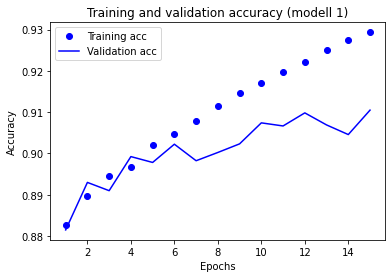

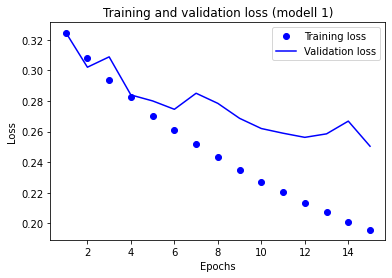

In [ ]:
epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notice how the training accuracy continously increases (and the loss continously decreases), while the validation accuracy and loss get to a plateau after some 12-14 epochs. The validation loss does not seems to rise significatly so we do not suspect it to overtrain, rather that the capcity (complexity) of the model is too small and the model can not do much better.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 2s 4ms/step - loss: 0.2795 - categorical_accuracy: 0.8983
Test accuracy: 0.898


# Övning Del 1a
## Frågor att besvara:
* Hur många parametrar har din modell?
>1,606,666st
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.)
> 89,8%
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad, vad i träningskurvorna kan avgöra det?

> Det verkar inte som att modellen är övertränad pga att validation acc inte försämras, training acc fortsätter att gå upp medans validation acc stannar av, vilket tyder på att modellen inte är komplex nog  

* Hur många epochs skulle ha varit lämpligt att använda?
>16-17 st

# Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen).
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då? 
* Målet är att få modellen att bli komplex nog att väl kunna representera data, men samtigt inte bli starkt övertränad.
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där verifieringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.

## Model 1 

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=64, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()


Input shape (28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1605696   
                                                                 
 dense_3 (Dense)             (


Test accuracy: 0.905
modellen verkar börjar överträna efter 13 epocher

##Model 2

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=64, activation='relu'),
Dense(units=64, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()


Input shape (28, 28, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1605696   
                                                                 
 dense_5 (Dense)             (

Test accuracy: 0.906,
vallidation acc blir plant efter 8 epocher

Epoch 1/15
1500/1500 [==============================] - 23s 15ms/step - loss: 0.6912 - categorical_accuracy: 0.7471 - val_loss: 0.4918 - val_categorical_accuracy: 0.8148
Epoch 2/15
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4211 - categorical_accuracy: 0.8476 - val_loss: 0.3643 - val_categorical_accuracy: 0.8697
Epoch 3/15
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3670 - categorical_accuracy: 0.8667 - val_loss: 0.3452 - val_categorical_accuracy: 0.8748
Epoch 4/15
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3280 - categorical_accuracy: 0.8805 - val_loss: 0.3207 - val_categorical_accuracy: 0.8839
Epoch 5/15
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2992 - categorical_accuracy: 0.8905 - val_loss: 0.3023 - val_categorical_accuracy: 0.8892
Epoch 6/15
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2754 - categorical_accuracy: 0.8977 - val_loss: 0.2738 - val_categoric

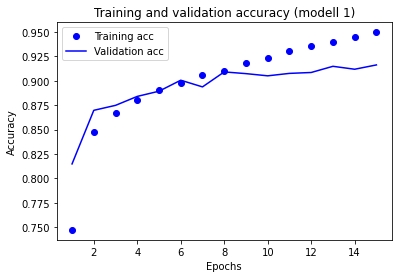

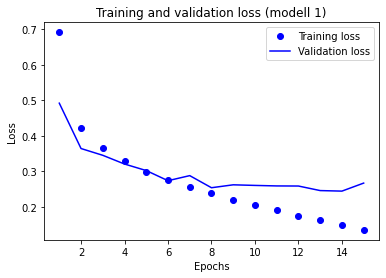

313/313 [==============================] - 2s 6ms/step - loss: 0.2945 - categorical_accuracy: 0.9059
Test accuracy: 0.906


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

##Model 3
120 filters 

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=120, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=120, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=120, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()



Input shape (28, 28, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 120)       1200      
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 120)       129720    
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 120)       129720    
                                                                 
 flatten_5 (Flatten)         (None, 94080)             0         
                                                                 
 dense_11 (Dense)            (None, 100)               9408100   
                                                                 
 dense_12 (Dense)            (None, 10)                1010      
                                                                 
Total params: 9,669,750
Traina

Epoch 1/15
1500/1500 [==============================] - 45s 29ms/step - loss: 0.6496 - categorical_accuracy: 0.7633 - val_loss: 0.4705 - val_categorical_accuracy: 0.8264
Epoch 2/15
1500/1500 [==============================] - 46s 30ms/step - loss: 0.4140 - categorical_accuracy: 0.8507 - val_loss: 0.3665 - val_categorical_accuracy: 0.8679
Epoch 3/15
1500/1500 [==============================] - 44s 29ms/step - loss: 0.3607 - categorical_accuracy: 0.8703 - val_loss: 0.3342 - val_categorical_accuracy: 0.8780
Epoch 4/15
1500/1500 [==============================] - 46s 31ms/step - loss: 0.3249 - categorical_accuracy: 0.8826 - val_loss: 0.3057 - val_categorical_accuracy: 0.8909
Epoch 5/15
1500/1500 [==============================] - 46s 31ms/step - loss: 0.2969 - categorical_accuracy: 0.8917 - val_loss: 0.2871 - val_categorical_accuracy: 0.8996
Epoch 6/15
1500/1500 [==============================] - 44s 29ms/step - loss: 0.2749 - categorical_accuracy: 0.8998 - val_loss: 0.2741 - val_categoric

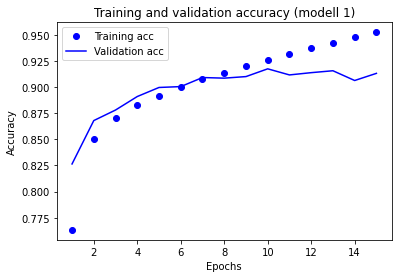

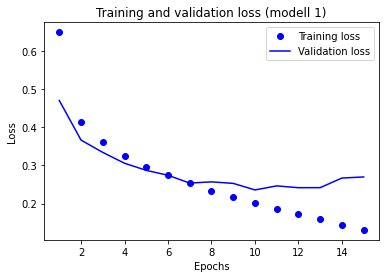

313/313 [==============================] - 4s 12ms/step - loss: 0.2889 - categorical_accuracy: 0.9057
Test accuracy: 0.906


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Test accuracy: 0.906,
börjar bli övertränad efter epoch 10,
tog betydligt längre tid att träna en tidigare modeller,

## Model 4

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()



Input shape (28, 28, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 64)        102464    
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 50176)             0         
                                                                 
 dense_13 (Dense)            (None, 100)               5017700   
                                                                 
 dense_14 (Dense)            (None, 10)                1010      
                                                                 
Total params: 5,159,766
Traina

Epoch 1/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.6521 - categorical_accuracy: 0.7617 - val_loss: 0.4434 - val_categorical_accuracy: 0.8340
Epoch 2/15
1500/1500 [==============================] - 24s 16ms/step - loss: 0.4001 - categorical_accuracy: 0.8551 - val_loss: 0.3501 - val_categorical_accuracy: 0.8745
Epoch 3/15
1500/1500 [==============================] - 25s 17ms/step - loss: 0.3464 - categorical_accuracy: 0.8731 - val_loss: 0.3302 - val_categorical_accuracy: 0.8826
Epoch 4/15
1500/1500 [==============================] - 24s 16ms/step - loss: 0.3109 - categorical_accuracy: 0.8857 - val_loss: 0.3012 - val_categorical_accuracy: 0.8902
Epoch 5/15
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2832 - categorical_accuracy: 0.8958 - val_loss: 0.2824 - val_categorical_accuracy: 0.8975
Epoch 6/15
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2616 - categorical_accuracy: 0.9042 - val_loss: 0.2606 - val_categoric

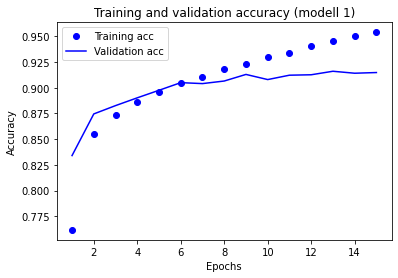

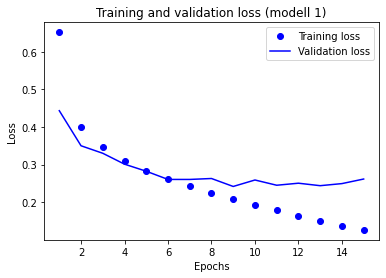

313/313 [==============================] - 3s 8ms/step - loss: 0.2891 - categorical_accuracy: 0.9085
Test accuracy: 0.909


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Test accuracy: 0.909, övertränad vid epoch 9

## Modell 5 
använder MaxPooling för att få ner antalet parametrar 

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()


Input shape (28, 28, 1)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 28, 28, 120)       3120      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 120)      0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 120)       360120    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 120)        0         
 2D)                                                             
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 120)         129720    
                                                                 
 flatten_9 (Flatten)         (

Epoch 1/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.8636 - categorical_accuracy: 0.6912 - val_loss: 0.5375 - val_categorical_accuracy: 0.7988
Epoch 2/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.4791 - categorical_accuracy: 0.8227 - val_loss: 0.4170 - val_categorical_accuracy: 0.8474
Epoch 3/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.4068 - categorical_accuracy: 0.8505 - val_loss: 0.3798 - val_categorical_accuracy: 0.8623
Epoch 4/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.3679 - categorical_accuracy: 0.8670 - val_loss: 0.3507 - val_categorical_accuracy: 0.8727
Epoch 5/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3422 - categorical_accuracy: 0.8763 - val_loss: 0.3261 - val_categorical_accuracy: 0.8821
Epoch 6/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3208 - categorical_accuracy: 0.8830 - val_loss: 0.3192 - val_categoric

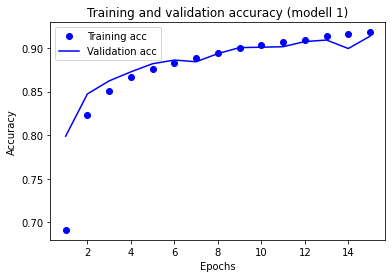

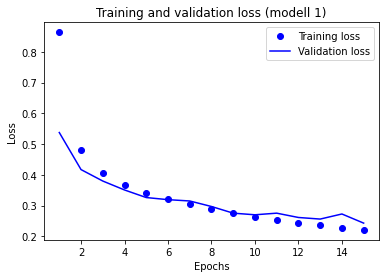

313/313 [==============================] - 3s 10ms/step - loss: 0.2736 - categorical_accuracy: 0.9014
Test accuracy: 0.901


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

In [ ]:
epochs = 10      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2135 - categorical_accuracy: 0.9218 - val_loss: 0.2426 - val_categorical_accuracy: 0.9152
Epoch 2/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2060 - categorical_accuracy: 0.9238 - val_loss: 0.2468 - val_categorical_accuracy: 0.9144
Epoch 3/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1993 - categorical_accuracy: 0.9261 - val_loss: 0.2356 - val_categorical_accuracy: 0.9160
Epoch 4/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1930 - categorical_accuracy: 0.9279 - val_loss: 0.2388 - val_categorical_accuracy: 0.9156
Epoch 5/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1860 - categorical_accuracy: 0.9317 - val_loss: 0.2431 - val_categorical_accuracy: 0.9131
Epoch 6/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1803 - categorical_accuracy: 0.9339 - val_loss: 0.2333 - val_categoric

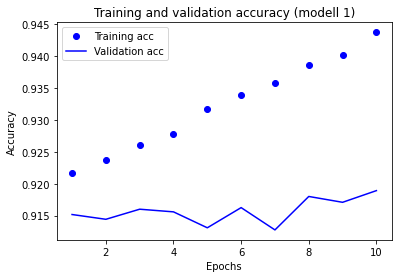

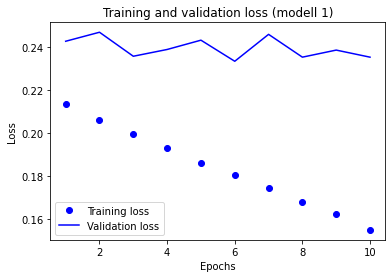

313/313 [==============================] - 3s 9ms/step - loss: 0.2642 - categorical_accuracy: 0.9075
Test accuracy: 0.908


In [ ]:
epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

## (Model 6)
provar adam istället för sgd

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()


Input shape (28, 28, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 120)       3120      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 120)      0         
 2D)                                                             
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 120)       360120    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 120)        0         
 2D)                                                             
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 7, 120)         129720    
                                                                 
 flatten_10 (Flatten)        

Epoch 1/15
1500/1500 [==============================] - 29s 19ms/step - loss: 0.4211 - categorical_accuracy: 0.8505 - val_loss: 0.3075 - val_categorical_accuracy: 0.8878
Epoch 2/15
1500/1500 [==============================] - 28s 18ms/step - loss: 0.2740 - categorical_accuracy: 0.9000 - val_loss: 0.2562 - val_categorical_accuracy: 0.9107
Epoch 3/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2240 - categorical_accuracy: 0.9161 - val_loss: 0.2359 - val_categorical_accuracy: 0.9148
Epoch 4/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1886 - categorical_accuracy: 0.9300 - val_loss: 0.2358 - val_categorical_accuracy: 0.9174
Epoch 5/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1584 - categorical_accuracy: 0.9409 - val_loss: 0.2400 - val_categorical_accuracy: 0.9239
Epoch 6/15
1500/1500 [==============================] - 26s 18ms/step - loss: 0.1346 - categorical_accuracy: 0.9486 - val_loss: 0.2625 - val_categoric

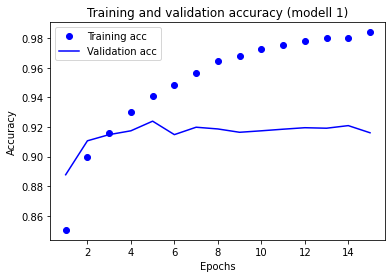

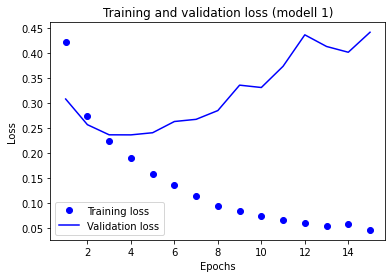

313/313 [==============================] - 3s 9ms/step - loss: 0.4537 - categorical_accuracy: 0.9155
Test accuracy: 0.915


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

In [ ]:
# Kod för din bästa modell och dess träning och utvärdering

## Model 7

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.

Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 7, 128)         409728    
                                                                 
 flatten_6 (Flatten)         (

Epoch 1/20
1920/1920 [==============================] - 29s 15ms/step - loss: 0.7944 - categorical_accuracy: 0.7158 - val_loss: 0.5179 - val_categorical_accuracy: 0.8091
Epoch 2/20
1920/1920 [==============================] - 23s 12ms/step - loss: 0.4450 - categorical_accuracy: 0.8363 - val_loss: 0.4202 - val_categorical_accuracy: 0.8462
Epoch 3/20
1920/1920 [==============================] - 24s 13ms/step - loss: 0.3777 - categorical_accuracy: 0.8628 - val_loss: 0.3653 - val_categorical_accuracy: 0.8679
Epoch 4/20
1920/1920 [==============================] - 23s 12ms/step - loss: 0.3416 - categorical_accuracy: 0.8760 - val_loss: 0.3381 - val_categorical_accuracy: 0.8776
Epoch 5/20
1920/1920 [==============================] - 23s 12ms/step - loss: 0.3163 - categorical_accuracy: 0.8828 - val_loss: 0.3333 - val_categorical_accuracy: 0.8793
Epoch 6/20
1920/1920 [==============================] - 23s 12ms/step - loss: 0.2965 - categorical_accuracy: 0.8903 - val_loss: 0.2998 - val_categoric

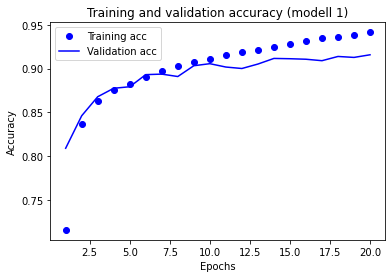

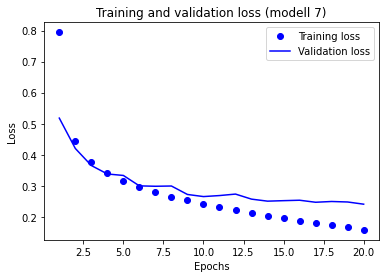

313/313 [==============================] - 3s 8ms/step - loss: 0.2670 - categorical_accuracy: 0.9047
Test accuracy: 0.905


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 20      ## Number of epoch to run
batch_size = 25  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 7)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

## Model 8

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),


# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 120)       3120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 120)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 120)       360120    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 120)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 120)         360120    
                                                                 
 flatten (Flatten)           (No

Epoch 1/25
1500/1500 [==============================] - 39s 20ms/step - loss: 0.8428 - categorical_accuracy: 0.7005 - val_loss: 0.5522 - val_categorical_accuracy: 0.7868
Epoch 2/25
1500/1500 [==============================] - 33s 22ms/step - loss: 0.4704 - categorical_accuracy: 0.8245 - val_loss: 0.4172 - val_categorical_accuracy: 0.8508
Epoch 3/25
1500/1500 [==============================] - 29s 20ms/step - loss: 0.3982 - categorical_accuracy: 0.8545 - val_loss: 0.3869 - val_categorical_accuracy: 0.8584
Epoch 4/25
1500/1500 [==============================] - 29s 19ms/step - loss: 0.3592 - categorical_accuracy: 0.8679 - val_loss: 0.3556 - val_categorical_accuracy: 0.8735
Epoch 5/25
1500/1500 [==============================] - 29s 20ms/step - loss: 0.3329 - categorical_accuracy: 0.8773 - val_loss: 0.3513 - val_categorical_accuracy: 0.8698
Epoch 6/25
1500/1500 [==============================] - 29s 19ms/step - loss: 0.3121 - categorical_accuracy: 0.8847 - val_loss: 0.3203 - val_categoric

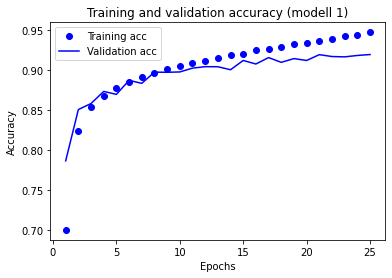

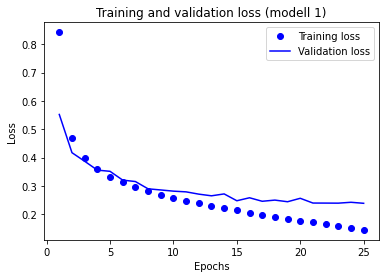

313/313 [==============================] - 3s 9ms/step - loss: 0.2579 - categorical_accuracy: 0.9098
Test accuracy: 0.910


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 20      ## Number of epoch to run
batch_size = 25  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

## Model 9

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
#keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=128, activation='relu'),

#keras.layers.Dropout(0.5),

Dense(units=64, activation='relu'),

#keras.layers.Dropout(0.5),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 128)         409728    
                                                                 
 max_pooling2d_11 (MaxPoolin  

###run the model

Epoch 1/20
1920/1920 [==============================] - 51s 22ms/step - loss: 1.1407 - categorical_accuracy: 0.5946 - val_loss: 0.7165 - val_categorical_accuracy: 0.7128
Epoch 2/20
1920/1920 [==============================] - 43s 22ms/step - loss: 0.5282 - categorical_accuracy: 0.8004 - val_loss: 0.4597 - val_categorical_accuracy: 0.8301
Epoch 3/20
1920/1920 [==============================] - 43s 23ms/step - loss: 0.4320 - categorical_accuracy: 0.8386 - val_loss: 0.3894 - val_categorical_accuracy: 0.8552
Epoch 4/20
1920/1920 [==============================] - 43s 22ms/step - loss: 0.3763 - categorical_accuracy: 0.8615 - val_loss: 0.3490 - val_categorical_accuracy: 0.8700
Epoch 5/20
1920/1920 [==============================] - 44s 23ms/step - loss: 0.3374 - categorical_accuracy: 0.8753 - val_loss: 0.3649 - val_categorical_accuracy: 0.8593
Epoch 6/20
1920/1920 [==============================] - 43s 23ms/step - loss: 0.3110 - categorical_accuracy: 0.8844 - val_loss: 0.3082 - val_categoric

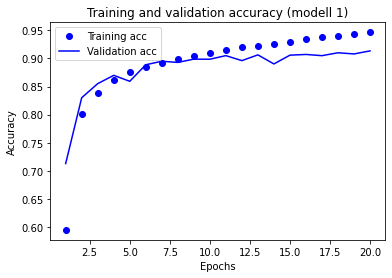

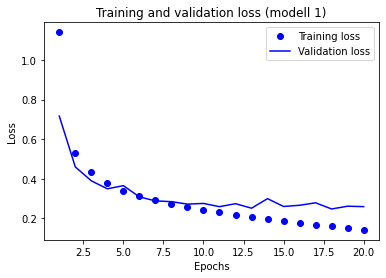

313/313 [==============================] - 4s 11ms/step - loss: 0.2778 - categorical_accuracy: 0.9054
Test accuracy: 0.905


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 20     ## Number of epoch to run
batch_size = 25  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

##Model 10 (Bästa modellen)

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=128, activation='relu'),

keras.layers.Dropout(0.5),

Dense(units=64, activation='relu'),

keras.layers.Dropout(0.5),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (

Epoch 1/25
1920/1920 [==============================] - 64s 33ms/step - loss: 1.2953 - categorical_accuracy: 0.5209 - val_loss: 0.6098 - val_categorical_accuracy: 0.7615
Epoch 2/25
1920/1920 [==============================] - 63s 33ms/step - loss: 0.6982 - categorical_accuracy: 0.7472 - val_loss: 0.4966 - val_categorical_accuracy: 0.8091
Epoch 3/25
1920/1920 [==============================] - 63s 33ms/step - loss: 0.5750 - categorical_accuracy: 0.7933 - val_loss: 0.4458 - val_categorical_accuracy: 0.8333
Epoch 4/25
1920/1920 [==============================] - 63s 33ms/step - loss: 0.5053 - categorical_accuracy: 0.8224 - val_loss: 0.4088 - val_categorical_accuracy: 0.8495
Epoch 5/25
1920/1920 [==============================] - 63s 33ms/step - loss: 0.4631 - categorical_accuracy: 0.8387 - val_loss: 0.3790 - val_categorical_accuracy: 0.8613
Epoch 6/25
1920/1920 [==============================] - 63s 33ms/step - loss: 0.4330 - categorical_accuracy: 0.8491 - val_loss: 0.3546 - val_categoric

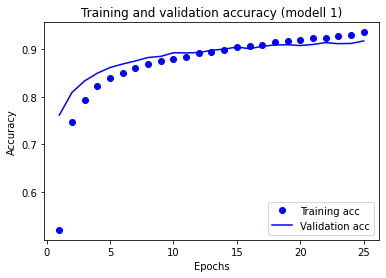

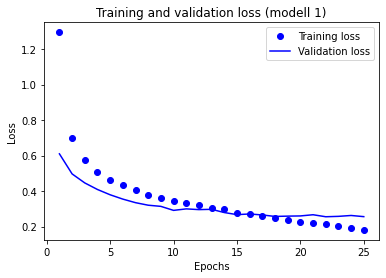

313/313 [==============================] - 4s 12ms/step - loss: 0.2891 - categorical_accuracy: 0.9104
Test accuracy: 0.910


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 25     ## Number of epoch to run
batch_size = 25  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

## Analys
Dokumentera dina experiment, med modellkonfiguration, testnoggrannhet, och vid vilken epoch modellen börjar överträna.
* Gör en sammanfattande analys av dina experiment hittills.
> sammanfattningsvis så fick jag runt 90% test accuracy på de flesta modellerna jag provade i början, där jag först provade med 4 CNN lager, 32 filter men provade sedan både fler lager med fler filer (några av dessa modellerna finns här ovan)

>jag provade också olika storlekar på kernellen (3x3 och 5x5) där en kombination av 3x3 och 5x5 verkade ge bäst resultat

> min bästa modell (modell 10) fick 91% test accuracy, den modellen är inspirerad av ett exempel från boken, 

> modell 8 fick också 91% test accuaracy, men när jag försökte fortsätta med den modellen på de andra lab momenten så verkade det som att den inte var komplex nog (varför?)

(provade också att använda adam istället för sdg i modell 6 vilket gav 91,5% test accuracy, men valde att inte ta med den modellen här då jag såg att man egentligen inte skulle byta optimerare förän upg 2c)

# Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [See Geron s. 141]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


### Modellen

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=128, activation='relu'),

keras.layers.Dropout(0.5),

Dense(units=64, activation='relu'),

keras.layers.Dropout(0.5),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          

### inför avbruten träning

In [ ]:
# Kod där du inför avbruten träning

# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 40      ## Number of epoch to run
batch_size = 25  ## Mini batch size

#early stop
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)

# Train the model.
history = model.fit( 
    train_images, to_categorical(train_labels), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose = 1, 
    callbacks=[es], 
    validation_data=(val_images, to_categorical(val_labels)) 
    )

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Epoch 1/40
1920/1920 [==============================] - 65s 33ms/step - loss: 1.3486 - categorical_accuracy: 0.5036 - val_loss: 0.6374 - val_categorical_accuracy: 0.7556
Epoch 2/40
1920/1920 [==============================] - 63s 33ms/step - loss: 0.7075 - categorical_accuracy: 0.7409 - val_loss: 0.5119 - val_categorical_accuracy: 0.7972
Epoch 3/40
1920/1920 [==============================] - 66s 34ms/step - loss: 0.5784 - categorical_accuracy: 0.7915 - val_loss: 0.4482 - val_categorical_accuracy: 0.8355
Epoch 4/40
1920/1920 [==============================] - 65s 34ms/step - loss: 0.5096 - categorical_accuracy: 0.8223 - val_loss: 0.3995 - val_categorical_accuracy: 0.8528
Epoch 5/40
1920/1920 [==============================] - 63s 33ms/step - loss: 0.4629 - categorical_accuracy: 0.8393 - val_loss: 0.3831 - val_categorical_accuracy: 0.8600
Epoch 6/40
1920/1920 [==============================] - 67s 35ms/step - loss: 0.4334 - categorical_accuracy: 0.8500 - val_loss: 0.3514 - val_categoric

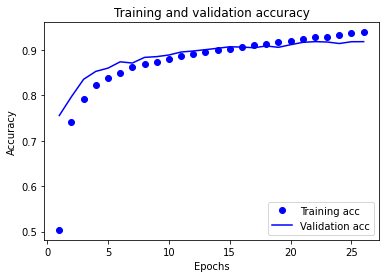

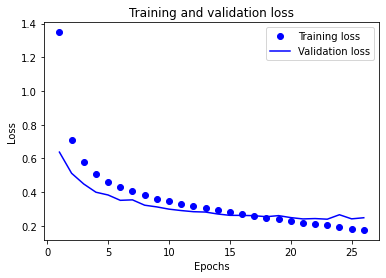

In [ ]:
epochrange = range(1, 26+ 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering. Analysera och jämför dessa modeller (med och utan regaluarisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [See Geron s 338, s. 365]

## Batchnormalisering

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# convolution layer 1
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# convolution layer 2
Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),

# convolution layer 3
Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# convolution layer 4
Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),

# convolution layer 5
Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

Dense(units=64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                              

In [ ]:
# Kod där du inför avbruten träning

# Compile the model, as a preparation for training

model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 40      ## Number of epoch to run
batch_size = 25  ## Mini batch size

#early stop
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)

# Train the model.
history = model.fit( 
    train_images, to_categorical(train_labels), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose = 1, 
    callbacks=[es], 
    validation_data=(val_images, to_categorical(val_labels)) 
    )

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Epoch 1/40
1920/1920 [==============================] - 72s 37ms/step - loss: 0.7618 - categorical_accuracy: 0.7467 - val_loss: 0.4019 - val_categorical_accuracy: 0.8518
Epoch 2/40
1920/1920 [==============================] - 70s 36ms/step - loss: 0.4489 - categorical_accuracy: 0.8517 - val_loss: 0.2981 - val_categorical_accuracy: 0.8925
Epoch 3/40
1920/1920 [==============================] - 69s 36ms/step - loss: 0.3844 - categorical_accuracy: 0.8743 - val_loss: 0.2663 - val_categorical_accuracy: 0.9032
Epoch 4/40
1920/1920 [==============================] - 69s 36ms/step - loss: 0.3255 - categorical_accuracy: 0.8960 - val_loss: 0.2759 - val_categorical_accuracy: 0.9048
Epoch 5/40
1920/1920 [==============================] - 69s 36ms/step - loss: 0.2982 - categorical_accuracy: 0.9038 - val_loss: 0.2402 - val_categorical_accuracy: 0.9158
Epoch 6/40
1920/1920 [==============================] - 69s 36ms/step - loss: 0.2688 - categorical_accuracy: 0.9131 - val_loss: 0.2391 - val_categoric

stannar efter 12 epocher med test accuracy 0.921

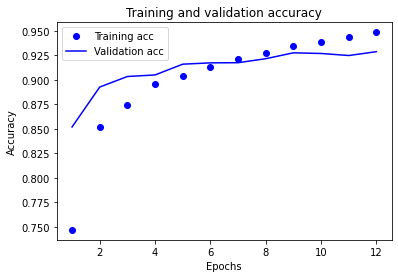

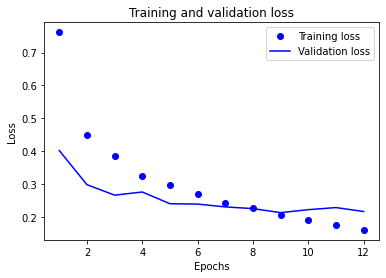

In [ ]:
#plotting the results
epochrange = range(1, 12+ 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Analys
Analysera och jämför dina modeller (med och utan regaluarisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? 

>(min modell från upg 1 använde redan regularisering, droput för att få ner parameterna lite, det jag ändrade i b-uppgiften är att jag också la till batchnormaliserings lager) 

>Med batchnormalisering (enligt ovan) fick jag test accuracy 0.921 efter 12 epocher, medans den tidigare modellen hade test accuracy 0.912 efter 26 epocher. alltså blev modellen både snabbare och bättre.     

# Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [See Geron s. 325.., s. 351.. ]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra)
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort färde kan ge instabil träning.

# Övning Del 2c
Byt ut optimeraren från sgd till adam (med regularisering och avbruten träning).

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# convolution layer 1
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# convolution layer 2
Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),

# convolution layer 3
Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# convolution layer 4
Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),

# convolution layer 5
Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

Dense(units=64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()


Input shape (28, 28, 1)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_15 (Bat  (None, 14, 14, 128)      512       
 chNormalization)                                                
                             

In [ ]:
# Din kod för en körning med adam som optimerare

# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 40      ## Number of epoch to run
batch_size = 25  ## Mini batch size

#early stop
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)

# Train the model.
history = model.fit( 
    train_images, to_categorical(train_labels), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose = 1, 
    callbacks=[es], 
    validation_data=(val_images, to_categorical(val_labels)) 
    )

# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Epoch 1/40
1920/1920 [==============================] - 73s 37ms/step - loss: 0.6420 - categorical_accuracy: 0.7840 - val_loss: 0.3871 - val_categorical_accuracy: 0.8597
Epoch 2/40
1920/1920 [==============================] - 71s 37ms/step - loss: 0.3958 - categorical_accuracy: 0.8676 - val_loss: 0.3207 - val_categorical_accuracy: 0.8912
Epoch 3/40
1920/1920 [==============================] - 72s 38ms/step - loss: 0.3314 - categorical_accuracy: 0.8898 - val_loss: 0.2816 - val_categorical_accuracy: 0.8972
Epoch 4/40
1920/1920 [==============================] - 72s 37ms/step - loss: 0.2982 - categorical_accuracy: 0.9013 - val_loss: 0.2647 - val_categorical_accuracy: 0.9050
Epoch 5/40
1920/1920 [==============================] - 72s 37ms/step - loss: 0.2704 - categorical_accuracy: 0.9110 - val_loss: 0.2757 - val_categorical_accuracy: 0.9056
Epoch 6/40
1920/1920 [==============================] - 71s 37ms/step - loss: 0.2404 - categorical_accuracy: 0.9211 - val_loss: 0.2424 - val_categoric

 ## Analys
Jämför träningsförfarandet mellan de två optimerarna (skillnad i testnoggrannhet, vilken epoch stannade träningen, etc.?). 


>Jag fick att testnogranheten var 0.918 med adam (stannade efter 10 epocher) och 0.921 med sgd (12 epocher), så sgd gav alltså ett bättre resultat, medans adam gav ett snabbare resultat. 


# Del 3 Auto tune
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner
# Due to a bug,we need to use an older version of Keras Tuner
!pip install keras_tuner==1.0.4 -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

Keras Tuner version: 1.0.4


## Exempelmodell (du ska sedan göra en egen!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5, 
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):  
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 1 och instrumentera den för att optimeras med Keras Tuner.

In [ ]:
# Kompletera denna kod med din modell
def build_model_MyModel(hp):  
  model = keras.Sequential([
    # First Convolutional Layer
    ##### YOUR CODE HERE! #####

# convolution layer 1
keras.layers.Conv2D(
    filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
    kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
    padding='same', 
    activation='relu', 
    input_shape=(28,28,1)
    ),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# convolution layer 2
keras.layers.Conv2D(
    filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
    kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
    padding='same', 
    activation='relu' 
    #input_shape=input_shape
    ),

# convolution layer 3
keras.layers.Conv2D(
    filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=32),
    kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
    padding='same', 
    activation='relu' 
    #input_shape=input_shape
    ),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# convolution layer 4
keras.layers.Conv2D(
    filters=hp.Int('conv_4_filter', min_value=32, max_value=256, step=32),
    kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
    padding='same', 
    activation='relu'
    #input_shape=input_shape
    ),

# convolution layer 5
keras.layers.Conv2D(
    filters=hp.Int('conv_5_filter', min_value=32, max_value=256, step=32),
    kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
    padding='same', 
    activation='relu'
    #input_shape=input_shape
    ),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

# Flatten the input. This prepares the vector for fully connected layers.
keras.layers.Flatten(),

# hidden Dense layer 1
keras.layers.Dense(
    units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
    activation='relu'
    ),
keras.layers.Dropout(hp.Float(name='dropout_rate1', min_value=.3, max_value=.7, step=.1)),

# hidden Dense layer 2
keras.layers.Dense(
    units=hp.Int('dense_2_units', min_value=32, max_value=256, step=32),
    activation='relu'
    ),
keras.layers.Dropout(hp.Float(name='dropout_rate2', min_value=.3, max_value=.7, step=.1)),

# A Final Dense Layer
keras.layers.Dense(10, activation='softmax')
  ])
  
  ##### You can also try some other learning rates in the next line, or use another optimizer with other parameters
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization. 

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

# Help it takes so much time!
Yes, doing a parameter search takes time! Using a K80 this search takes 1h24 (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run to in steps, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multistep process, please document it well!

In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels, 
             epochs=noepochauto, 
             validation_data=(val_images, val_labels), 
             callbacks=[es])

In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))
    
model.summary()

       conv_1_filter = 160
       conv_1_kernel =   3
       conv_2_filter =  32
       conv_2_kernel =   3
       conv_3_filter =  64
       conv_3_kernel =   3
       conv_4_filter =  32
       conv_4_kernel =   3
       conv_5_filter = 160
       conv_5_kernel =   3
       dense_1_units = 256
       dropout_rate1 = 0.5
       dense_2_units = 192
       dropout_rate2 = 0.7
       learning_rate = 0.001
          batch_size =  32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 96)        221280    
                  

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

## Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation. 

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
167/167 [==============================] - 19s 109ms/step - loss: 0.2043 - accuracy: 0.9272 - val_loss: 0.2320 - val_accuracy: 0.9148
Epoch 2/30
167/167 [==============================] - 17s 102ms/step - loss: 0.1855 - accuracy: 0.9322 - val_loss: 0.2187 - val_accuracy: 0.9244
Epoch 3/30
167/167 [==============================] - 17s 102ms/step - loss: 0.1702 - accuracy: 0.9388 - val_loss: 0.2486 - val_accuracy: 0.9122
Epoch 4/30
167/167 [==============================] - 17s 102ms/step - loss: 0.1554 - accuracy: 0.9427 - val_loss: 0.2212 - val_accuracy: 0.9229
Epoch 4: early stopping


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 4s 13ms/step - loss: 0.2603 - accuracy: 0.9155
Test accuracy: 0.915


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 96)        307296    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 192)       460992    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 192)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 192)         9

#Analys
Gör en komplett analys av de optimerade modelerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden från de värden då fått fram i del 1 och del 2, jämfört med de som kom fram mha en Bayesiask sökning? 
* Vilka prestanda fick du för de två fallen? 
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?)
* Vilka hyperparametrar verkade vara mest betydelsfulla? 
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)? 
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång?
* Annat som du iaktagit?

keras tuner gav en model med 1912810 parametrar, och nätverkets lager strukturerades enligt följande: 

       conv_1_filter = 160
       conv_1_kernel =   3
       conv_2_filter =  32
       conv_2_kernel =   3
       conv_3_filter =  64
       conv_3_kernel =   3
       conv_4_filter =  32
       conv_4_kernel =   3
       conv_5_filter = 160
       conv_5_kernel =   3
       dense_1_units = 256
       dropout_rate1 = 0.5
       dense_2_units = 192
       dropout_rate2 = 0.7
       learning_rate = 0.001
          batch_size =  32

Där vi ser att dense_1_units och dropout_rate2 båda ligger på den övre gränsen av den använda sökrymden

antalet fältningskärnor varierar mellan 32 och 160 mellan de olika lagren, där lager med många kärnor verkar följas av lager med färre kärnor, kernel storleken blev 3x3 på samtliga fältningslager.

Denna modellen hade: val_accuracy: 0.9229 och Test accuracy: 0.915
vilket var bättre än modellen från upg1 (val_categorical_accuracy: 0.9172, Test accuracy: 0.910) men sämre än den från upg2 (val_categorical_accuracy: 0.9286, Test accuracy: 0.921)

Anledningen till att man utför samma experiement flera gånger och att resultatet inte är det samma varje gång är att resultaten som fås kan variera beroende på hur modellen tränas. alltså är det mer robust att köra det flera gånger.     



# Uppgifter för väl godkänt

Utökning av Del2: Utforska de testfall som missklassificerades för en av dina toppmodeller, vilka typer av plagg verkar vara de som oftast blir fel på, om du tittar på dessa fel förstår du varför nätet har problem med dem?

In [ ]:
# Din kod som utforskar de testfall som missklassificerades

Utökning av Del3: Implementera en undersökning där du även varierar antal lager i din modell, du kan ändra både faltningslager och kompakta lager (eng. dense layers) för att se ifall en ännu bättre modell kan hittas.

In [ ]:
# Din kod för en keras tuner modell som har antalet lager som en hyperparameter

In [ ]:
#Test1 avbruten träning
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simples Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

Conv2D(filters=120, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=100, activation='relu'),


# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()


Input shape (28, 28, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 120)       3120      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 120)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 120)       360120    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 120)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 120)         129720    
                                                                 
 flatten_4 (Flatten)         (